In [1]:
# Import all libraries
%env CUDA_LAUNCH_BLOCKING=1
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects,binary_opening, generate_binary_structure
from torchvision.transforms import v2

env: CUDA_LAUNCH_BLOCKING=1


In [2]:
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

CUDA available: True
Device name: NVIDIA GeForce RTX 4070 Ti SUPER


In [3]:
#IF USING GOOGLE DRIVE UNCOMMENT
# from google.colab import drive
# drive.mount('/content/drive')
# data_path = '/content/drive/My Drive/Deep Learning Final/train_data.npz'

data_path = 'counting-cells-in-microscopy-images-2023/train_data.npz'

# New Section

Arrays in file: ['X', 'y']
x: (2000, 128, 128)
y: (2000, 128, 128)


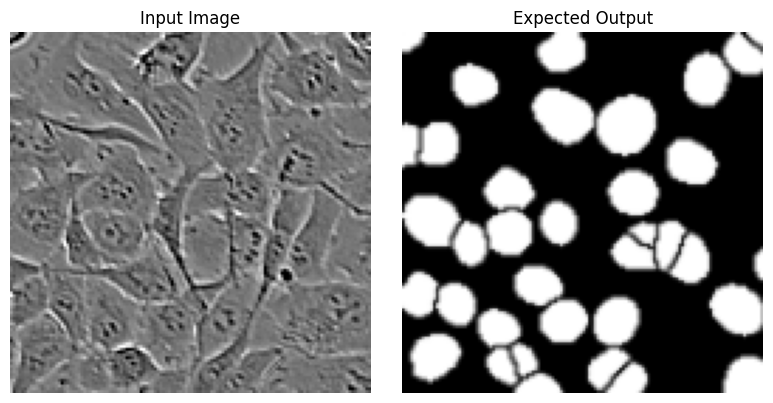

In [4]:
# Import cell pictures and labels

#Uncomment for google drive

data = np.load(data_path)

x = data['X']
y = data['y']

# y = np.loadtxt('counting-cells-in-microscopy-images-2023/cellcount.csv', delimiter=",", dtype=float)

# X = X.reshape(X.shape[0],1,128,128)
print("Arrays in file:", data.files)
print("x:", x.shape)
print("y:", y.shape)

idx = 0

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(data['X'][idx], cmap='gray')
axes[0].set_title("Input Image")
axes[0].axis('off')

axes[1].imshow(data['y'][idx], cmap='gray')
axes[1].set_title("Expected Output")
axes[1].axis('off')

plt.tight_layout()
plt.show()

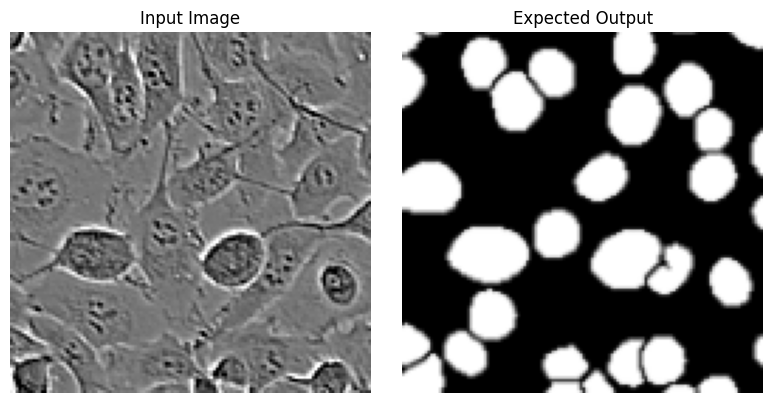

1.0


In [108]:
from torchvision import transforms, tv_tensors
import torchvision.transforms.v2 as v2
import torch

torch.manual_seed(20)

# Compose random transforms
transform = v2.Compose([
    v2.RandomApply([v2.RandomRotation([90, 90])], p=0.65),
    v2.RandomApply([v2.RandomHorizontalFlip(p=1.0)], p=0.65),
    v2.RandomApply([v2.RandomVerticalFlip(p=1.0)], p=0.65),
    v2.RandomApply([v2.GaussianBlur(kernel_size=3, sigma=(0.5, 0.5))], p=0.65)
])

torx = torch.from_numpy(x) #has 2000 images
tory = torch.from_numpy(y)

# Convert numpy image to tensor
img_tensor = tv_tensors.Image(torx)
mask_tensor = tv_tensors.Mask(tory)

# Apply same transform to both
tx, ty = transform(img_tensor, mask_tensor) #2000 images

combined_images = torch.cat([tx, torx], dim=0).numpy()  # [4000, C, H, W]
combined_masks = torch.cat([ty, tory], dim=0).numpy()   # [4000, H, W]

# print(type(combined_images))
# print(len(combined_images))

idx = 1

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(combined_images[idx], cmap='gray')
axes[0].set_title("Input Image")
axes[0].axis('off')

axes[1].imshow(combined_masks[idx], cmap='gray')
axes[1].set_title("Expected Output")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [6]:
print(combined_images.shape)

(4000, 128, 128)


In [7]:
import torch
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images  # shape [N, H, W]
        self.masks = masks    # shape [N, H, W]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]      # [H, W]
        mask = self.masks[idx]      # [H, W]

        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)   # [1, H, W]
        mask = torch.tensor(mask, dtype=torch.long)

        return img, mask



In [98]:
np.save('combined-images.npy', combined_images)
np.save('combined-masks.npy', combined_masks)

In [8]:
from torch.utils.data import random_split, DataLoader

full_dataset = SegmentationDataset(combined_images, combined_masks)

# 80% train, 10% val, 10% test
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size])

In [9]:
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
import segmentation_models_pytorch as smp

model = smp.Unet("resnet18", encoder_weights=None, in_channels=1 ,classes=5)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


c:\Users\Nicholas\AppData\Roaming\Python\DeepL\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
for epoch in range(100):
    model.train()
    train_loss = 0.0

    for imgs, masks in train_loader:
        #print(imgs.shape)
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)  # shape [B, 5, H, W]
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")


Epoch 1, Train Loss: 0.2308
Epoch 2, Train Loss: 0.1231
Epoch 3, Train Loss: 0.1117
Epoch 4, Train Loss: 0.1058
Epoch 5, Train Loss: 0.1004
Epoch 6, Train Loss: 0.0965
Epoch 7, Train Loss: 0.0934
Epoch 8, Train Loss: 0.0897
Epoch 9, Train Loss: 0.0863
Epoch 10, Train Loss: 0.0830
Epoch 11, Train Loss: 0.0797
Epoch 12, Train Loss: 0.0765
Epoch 13, Train Loss: 0.0732
Epoch 14, Train Loss: 0.0700
Epoch 15, Train Loss: 0.0672
Epoch 16, Train Loss: 0.0646
Epoch 17, Train Loss: 0.0621
Epoch 18, Train Loss: 0.0598
Epoch 19, Train Loss: 0.0572
Epoch 20, Train Loss: 0.0555
Epoch 21, Train Loss: 0.0538
Epoch 22, Train Loss: 0.0516
Epoch 23, Train Loss: 0.0500
Epoch 24, Train Loss: 0.0486
Epoch 25, Train Loss: 0.0472
Epoch 26, Train Loss: 0.0460
Epoch 27, Train Loss: 0.0447
Epoch 28, Train Loss: 0.0438
Epoch 29, Train Loss: 0.0429
Epoch 30, Train Loss: 0.0417
Epoch 31, Train Loss: 0.0407
Epoch 32, Train Loss: 0.0400
Epoch 33, Train Loss: 0.0394
Epoch 34, Train Loss: 0.0387
Epoch 35, Train Loss: 0

In [12]:
torch.save(model.state_dict(), 'trained_model_weights.pth')

In [68]:
print(len(test_loader))

50


In [59]:
import torch

model.eval()  # evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_preds = []
all_gts = []

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        outputs = model(imgs)  # [B, C, H, W]
        preds = torch.argmax(outputs, dim=1)  # [B, H, W] - class predictions

        all_preds.append(preds.cpu())
        all_gts.append(masks.cpu())


torch.Size([8, 5, 128, 128])


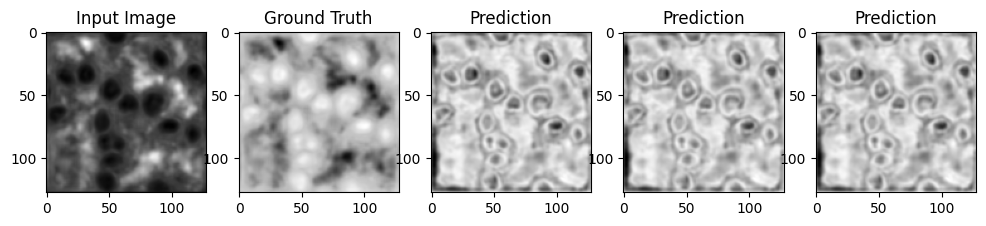

In [107]:
print(outputs.shape)

outputs = outputs.cpu()

plt.figure(figsize=(12, 4))
plt.subplot(1, 5, 1)
plt.imshow(outputs[1][0], cmap='gray')
plt.title("Input Image")
plt.subplot(1, 5, 2)
plt.imshow(outputs[1][1], cmap='gray')
plt.title("Ground Truth")
plt.subplot(1, 5, 3)
plt.imshow(outputs[1][2], cmap='gray')
plt.title("Prediction")
plt.subplot(1, 5, 4)
plt.imshow(outputs[1][3], cmap='gray')
plt.title("Prediction")
plt.subplot(1, 5, 5)
plt.imshow(outputs[1][4], cmap='gray')
plt.title("Prediction")
plt.show()



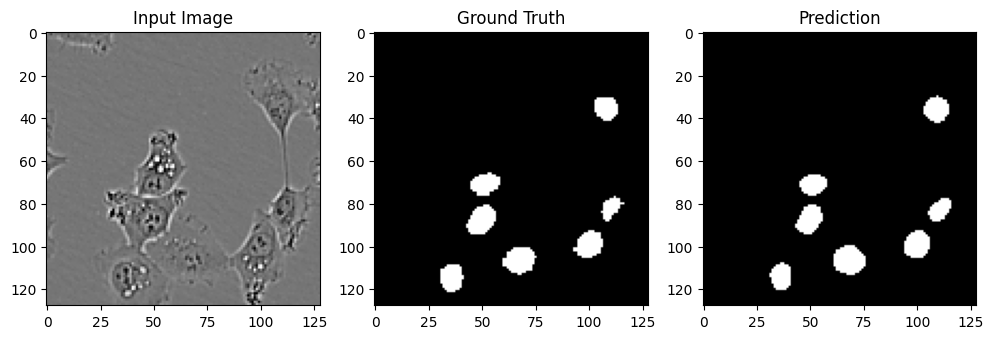

In [72]:
import matplotlib.pyplot as plt

# Pick one example
val = 7

img = imgs[val].cpu().squeeze().numpy()         # [H, W]
mask = masks[val].cpu().numpy()                 # [H, W]
pred = preds[val].cpu().numpy()                 # [H, W]

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Input Image")
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth")
plt.subplot(1, 3, 3)
plt.imshow(pred, cmap='gray')
plt.title("Prediction")
plt.show()

#Make three copy colour channels to get pretrained

In [73]:
correct = (preds == masks).sum().item()
total = torch.numel(masks)
accuracy = correct / total
print(f"Pixel Accuracy: {accuracy:.4f}")


Pixel Accuracy: 0.9688


In [78]:
correct = 0
total = 0
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == masks).sum().item()
        total += masks.numel()

print(f"Test Accuracy: {correct / total:.4f}")


Test Accuracy: 0.9583


In [65]:
from segmentation_models_pytorch.utils.metrics import IoU, Fscore

iou_metric = IoU(threshold=0.5)
dice_metric = Fscore(threshold=0.5)

iou = iou_metric(preds, masks)
dice = dice_metric(preds, masks)

print(f"IoU: {iou:.4f} | Dice: {dice:.4f}")

#silouette, davies boltens index


IoU: 0.7539 | Dice: 0.8597


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Found 7 circular regions


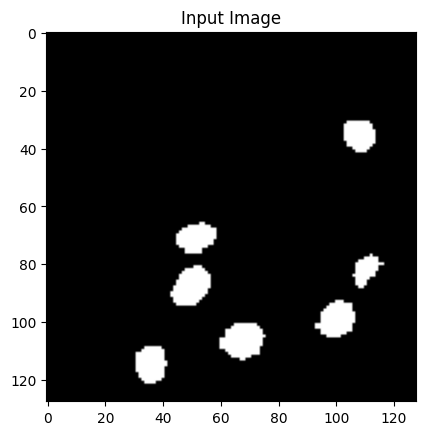

In [90]:
import cv2
import numpy as np

plt.imshow(mask, cmap='gray')
plt.title("Input Image")

circle_mask = (mask > 0).astype(np.uint8) * 255
#circle_mask = (pred > 0).astype(np.uint8) * 255
#circle_mask = (output > 0).astype(np.uint8) * 255
print(circle_mask)

# Find contours
contours, _ = cv2.findContours(circle_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Optional: filter by circularity
circle_like_contours = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    if perimeter == 0:
        continue
    circularity = 4 * np.pi * (area / (perimeter * perimeter))
    if 0.7 < circularity <= 1.2:  # adjust range as needed
        circle_like_contours.append(cnt)

print(f"Found {len(contours)} circular regions")


In [96]:
pred_total = 0
gt_total = 0

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for raw, gt in test_loader:
        raw = raw.to(device)
        gt = gt.to(device)

        # Predict mask from model
        output = model(raw)  # shape: (B, C, H, W) or (B, 1, H, W)
        
        # Assume binary or multi-class, take argmax if needed
        if output.shape[1] > 1:
            pmask = torch.argmax(output, dim=1)  # shape: (B, H, W)
        else:
            pmask = (output > 0.5).long().squeeze(1)  # shape: (B, H, W)

        # Loop over each image in the batch
        for pred_mask, true_mask in zip(pmask, gt):
            # Convert to numpy
            pred_mask_np = pred_mask.cpu().numpy().astype(np.uint8) * 255
            true_mask_np = true_mask.cpu().numpy().astype(np.uint8) * 255

            # Find contours
            pred_contours, _ = cv2.findContours(pred_mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            true_contours, _ = cv2.findContours(true_mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Count contours
            pred_total += len(pred_contours)
            gt_total += len(true_contours)

print(f"Total Predicted Circles: {pred_total}")
print(f"Total Ground Truth Circles: {gt_total}")

print((pred_total-gt_total)/gt_total*100)


Total Predicted Circles: 8352
Total Ground Truth Circles: 8166
2.2777369581190303
